In [118]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import seaborn as sns
sns.set_context('notebook')

In [120]:
from agnfinder.tf_sampling import parameter_recovery

1302 galaxies loaded [00:00, 4979.43 galaxies loaded/s]
436 galaxies loaded [00:06, 90.28 galaxies loaded/s]/home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:113: RuntimeWarning: invalid value encountered in greater
  num_geq_80p = (galaxy_marginals.transpose() > value_for_80p).sum(axis=0)
1302 galaxies loaded [00:07, 185.64 galaxies loaded/s]
/home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning: invalid value encountered in true_divide
  posterior_record[n] = posterior_record[n] / galaxy_counts[n]


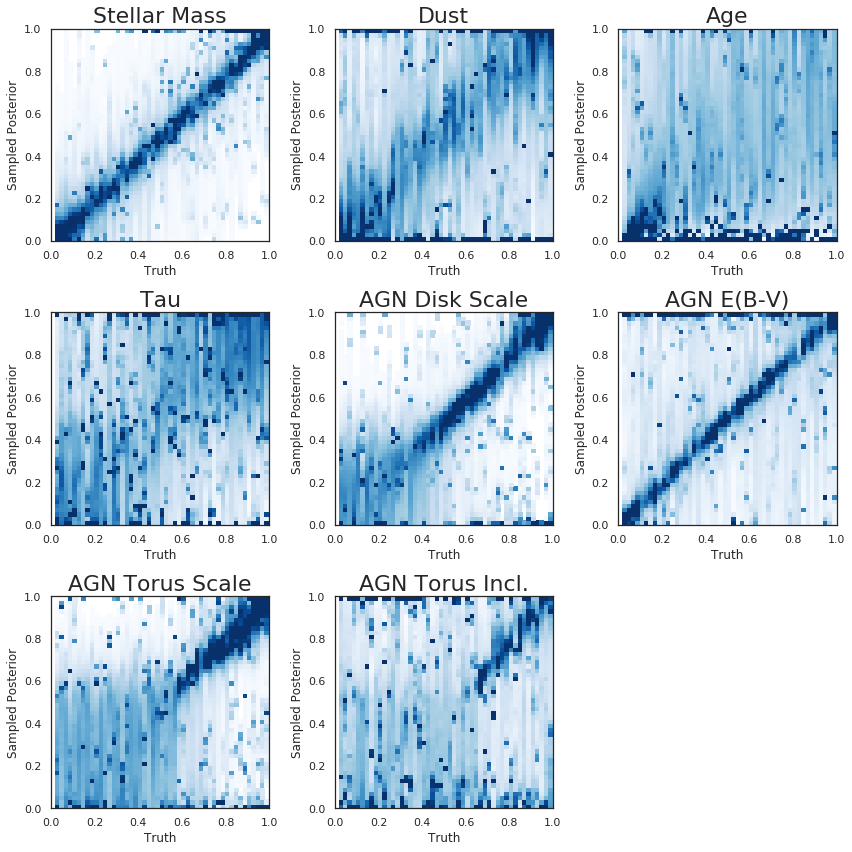

In [121]:
save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
fig, axes = parameter_recovery.main(save_dir, 0.6, 4)

In [122]:
# params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk', 'AGN E(B-V)', 'AGN Torus', 'Inclination']


In [218]:
# all_marginals = np.random.rand(10000, len(params), 50)
# all_true_params = np.random.rand(10000, len(params))
params, all_marginals, all_true_params = parameter_recovery.load_samples(save_dir, min_acceptance=0.6, max_redshift=1.)
# params = parameter_recovery.rename_params(params)
n_param_bins=50
n_posterior_bins=50

1645 galaxies loaded [00:00, 5512.85 galaxies loaded/s]
759 galaxies loaded [00:22, 163.67 galaxies loaded/s]/home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:113: RuntimeWarning: invalid value encountered in greater
  num_geq_80p = (galaxy_marginals.transpose() > value_for_80p).sum(axis=0)
1645 galaxies loaded [00:23, 70.69 galaxies loaded/s] 


In [219]:
# for real

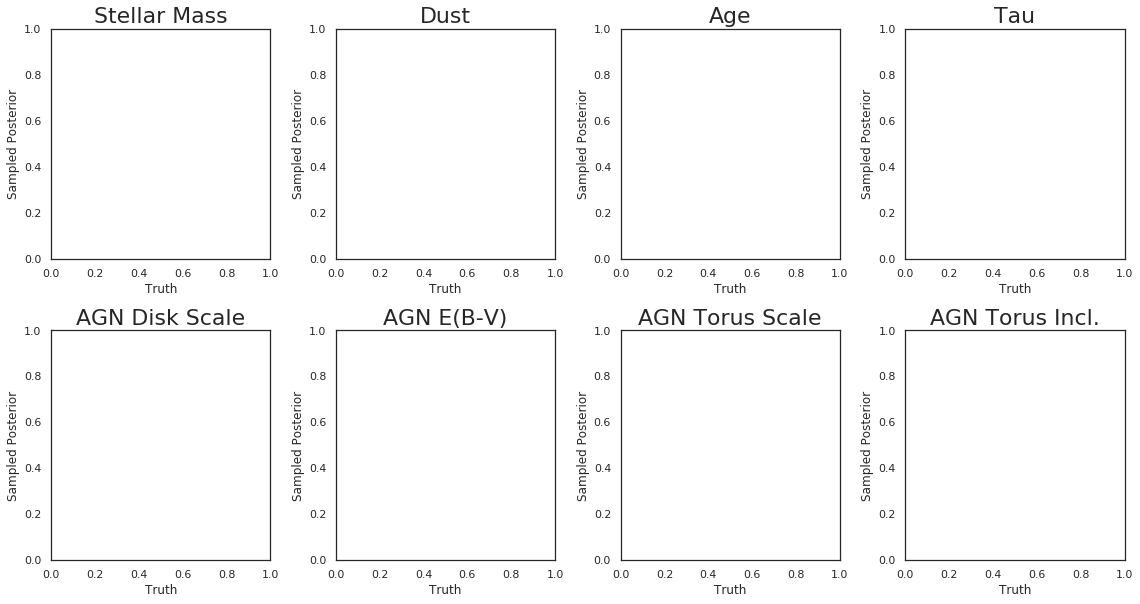

In [233]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 9.5))
all_axes = [ax for col in axes for ax in col]
sns.set_context('notebook')
sns.set_style('white')
for param_n, ax in enumerate(all_axes):
    ax.grid(False)
    if param_n < len(params):
        # ax.plot([0., 50.], [0., 50.], 'k--', alpha=0.3)
        ax.set_title('{}'.format(params[param_n]), fontsize=22)
        ax.set_xlabel('Truth')
        ax.set_ylabel(r'Sampled Posterior')
for ax_n, ax in enumerate(all_axes):
    if ax_n >= len(params):
        ax.remove()
fig.tight_layout(rect=[0,0.1,1,1])

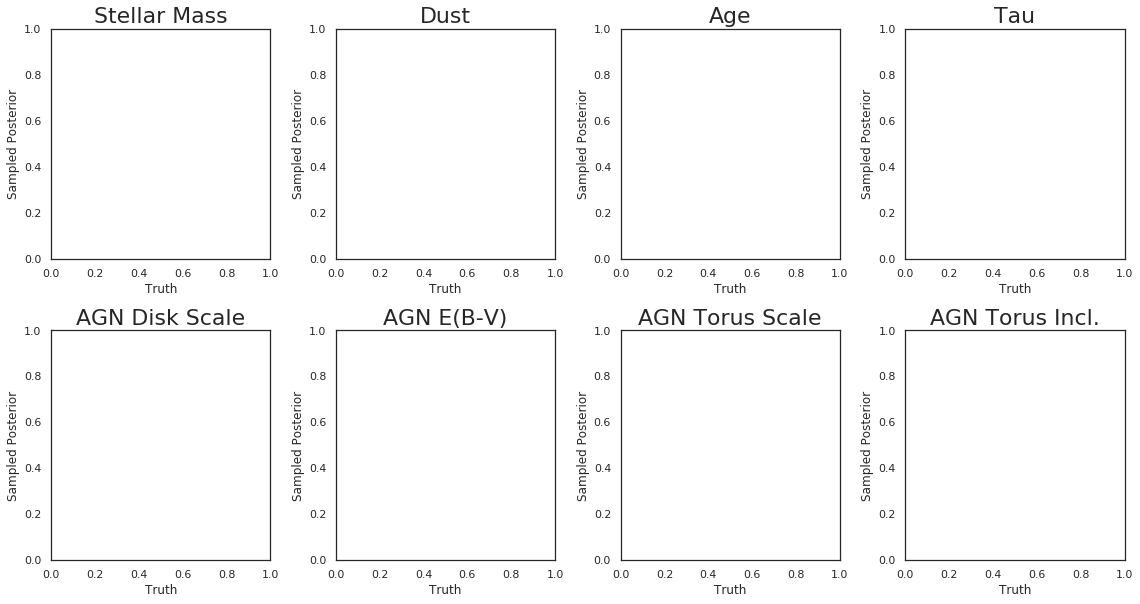

In [234]:
fig

In [235]:
params

['Stellar Mass',
 'Dust',
 'Age',
 'Tau',
 'AGN Disk Scale',
 'AGN E(B-V)',
 'AGN Torus Scale',
 'AGN Torus Incl.']

In [236]:
n_frames = 20
def get_n_galaxies(i):
    return int(np.logspace(np.log10(1), np.log10(len(all_marginals)), num=n_frames)[i])

In [237]:
# latest_text = None
def update(i):
#     print(latest_text)
    n_galaxies = get_n_galaxies(i)
    marginals = all_marginals[:n_galaxies]
    true_params = all_true_params[:n_galaxies]
        # with a made up array, get the bins to use
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=n_param_bins)

    for param_n in range(len(params)):
        ax = all_axes[param_n]
        posterior_record = np.zeros((n_param_bins, n_posterior_bins)) * 0
        posterior_colors = np.zeros((n_param_bins, n_posterior_bins, 4)) * 0
        galaxy_counts = np.zeros((n_param_bins))  # to track how many galaxies have been added
        for galaxy_n, _ in enumerate(marginals):
            true_param = true_params[galaxy_n, param_n]
            true_param_index = np.digitize(true_param, param_bins)  # fnd the bin index for true_param
            # print(true_param_index)
            stripe = marginals[galaxy_n, param_n]
            if true_param_index < n_param_bins:  # exclude =50 edge case TODO
                posterior_record[true_param_index] += np.nan_to_num(stripe)  # nans to 0's
                # posterior_record[true_param_index] = stripe
                galaxy_counts[true_param_index] += 1

        # print(posterior_record[:, 0])
        # print(posterior_record)
        # divide out by how many galaxies were added at each index
        # posterior_record = posterior_record / galaxy_counts
        for n in range(len(galaxy_counts)):
            posterior_record[n] = posterior_record[n] / galaxy_counts[n]
        # print(posterior_record)
        # replace any 0's with nans, for clarity
        posterior_record[np.isclose(posterior_record, 0)] = np.nan
        # trim extreme values
        ceiling = np.quantile(posterior_record[~np.isnan(posterior_record)], .95)
        posterior_record = np.clip(posterior_record, 0, ceiling)

        # plot in single color
        ax.pcolormesh(param_bins, param_bins, np.transpose(posterior_record), cmap='Blues')  
    for txt in all_axes[3].texts:
        txt.set_visible(False)
#     if latest_text is not None:
#         latest_text.set_visible(False)
    latest_text = all_axes[3].text(-2.1, -1.65, f'Galaxies: {n_galaxies}',  fontsize=30.)

In [238]:
# all_axes[-2].texts

/home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


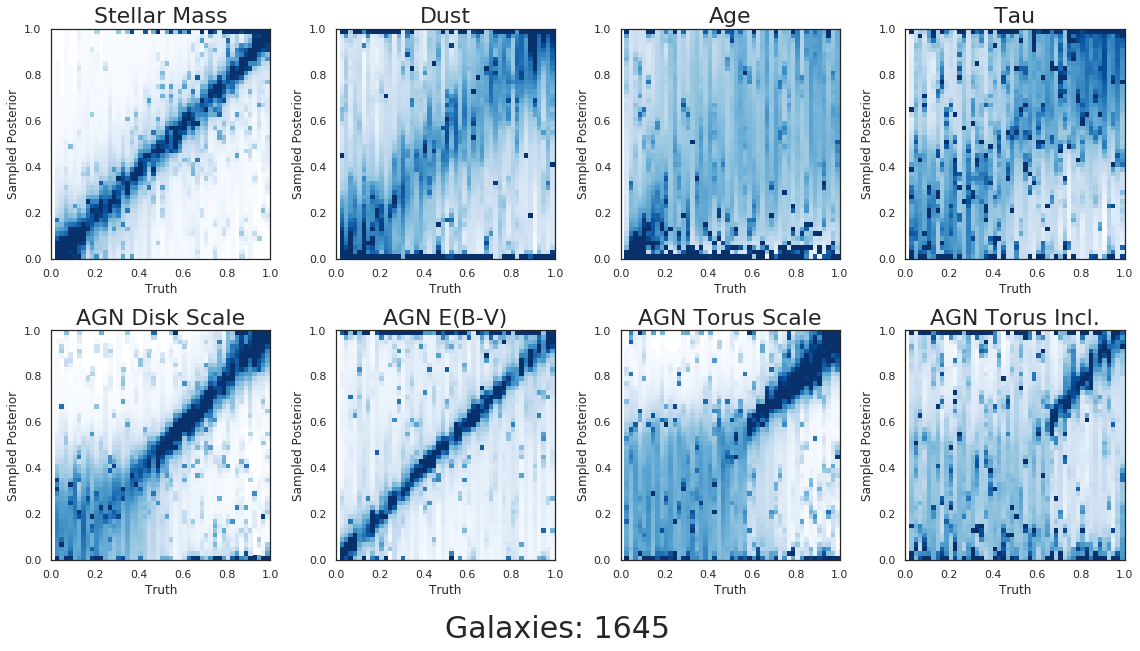

In [241]:
update(19)
fig

In [228]:
# for i in range(1, n_frames):
#     print(i)
#     update(i)

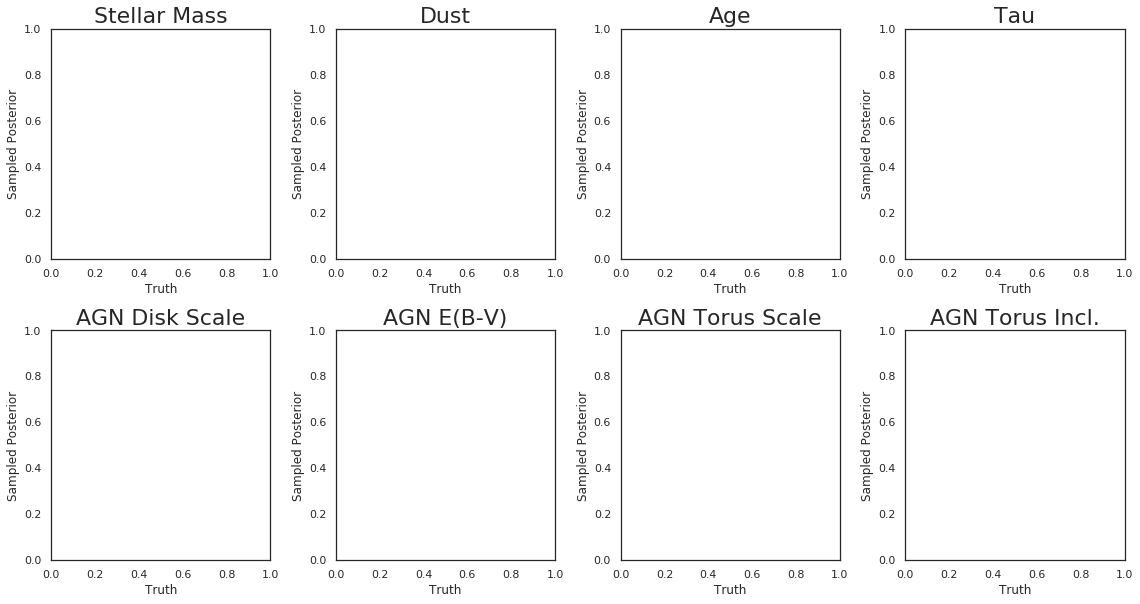

In [229]:
fig

In [230]:
!pwd

/home/walml/repos/agnfinder/notebooks/inference


In [231]:

anim = FuncAnimation(fig, update, frames=np.arange(0, n_frames), interval=1000, repeat=False, repeat_delay=100000)
anim.save('temp.gif', dpi=80, writer='imagemagick')
#     if len(sys.argv) > 1 and sys.argv[1] == 'save':
#         
#     else:
    # plt.show() will just loop the animation forever.
# plt.show()


/home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [ ]:

# with a made up array, get the bins to use
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=n_param_bins)

for param_n in range(len(params)):
    ax = all_axes[param_n]
    posterior_record = np.zeros((n_param_bins, n_posterior_bins)) * 0
    posterior_colors = np.zeros((n_param_bins, n_posterior_bins, 4)) * 0
    galaxy_counts = np.zeros((n_param_bins))  # to track how many galaxies have been added
    for galaxy_n, _ in enumerate(marginals):
        true_param = true_params[galaxy_n, param_n]
        true_param_index = np.digitize(true_param, param_bins)  # fnd the bin index for true_param
        # print(true_param_index)
        stripe = marginals[galaxy_n, param_n]
        if true_param_index < n_param_bins:  # exclude =50 edge case TODO
            posterior_record[true_param_index] += np.nan_to_num(stripe)  # nans to 0's
            # posterior_record[true_param_index] = stripe
            galaxy_counts[true_param_index] += 1

    # print(posterior_record[:, 0])
    # print(posterior_record)
    # divide out by how many galaxies were added at each index
    # posterior_record = posterior_record / galaxy_counts
    for n in range(len(galaxy_counts)):
        posterior_record[n] = posterior_record[n] / galaxy_counts[n]
    # print(posterior_record)
    # replace any 0's with nans, for clarity
    posterior_record[np.isclose(posterior_record, 0)] = np.nan
    # trim extreme values
    ceiling = np.quantile(posterior_record[~np.isnan(posterior_record)], .95)
    posterior_record = np.clip(posterior_record, 0, ceiling)

    # plot in single color
    ax.pcolormesh(param_bins, param_bins, np.transpose(posterior_record), cmap='Blues')  
    # OR plot colored by value of one param
    # coloring_param_index = 5
    # for galaxy_n, galaxy in enumerate(marginals):
    #     custom_cmap = get_cmap(true_params[galaxy_n, coloring_param_index])
    #     true_param = true_params[galaxy_n, param_n]
    #     true_param_index = np.digitize(true_param, param_bins)  # find the bin index for true_param
    #     if true_param_index < n_param_bins:  # exclude =50 edge case TODO
    #         posterior_colors[true_param_index] = custom_cmap(posterior_record[true_param_index])
    # ax.imshow(np.transpose(posterior_colors, axes=[1, 0, 2]), origin='lower')

    ax.grid(False)
    # ax.plot([0., 50.], [0., 50.], 'k--', alpha=0.3)
    ax.set_title('{}'.format(params[param_n]), fontsize=22)
    ax.set_xlabel('Truth')
    ax.set_ylabel(r'Sampled Posterior')

In [17]:
params = ['redshift', 'mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling', 'inclination']
marginals = np.random.rand(10, len(params))
true_params = np.random.rand(10, len(params))

/home/mike/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning: invalid value encountered in true_divide
  posterior_record[n] = posterior_record[n] / galaxy_counts[n]


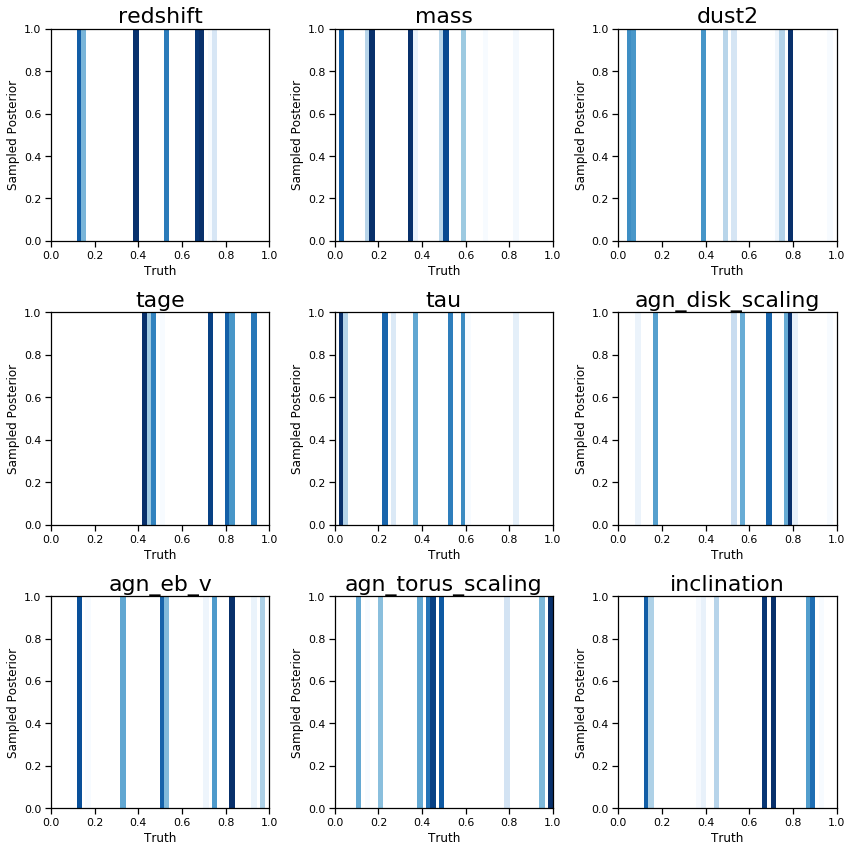

In [19]:
fig, ax = parameter_recovery.plot_posterior_stripes(params, marginals, true_params)

fig size: 72.0 DPI, size in inches [6. 4.]
timestep 0


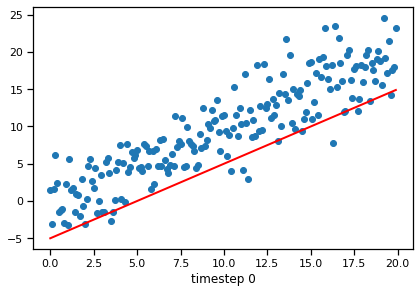

In [14]:

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
#     if len(sys.argv) > 1 and sys.argv[1] == 'save':
#         
#     else:
    # plt.show() will just loop the animation forever.
plt.show()


In [15]:
anim.save('line.gif', dpi=80, writer='imagemagick')

timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
